In [5]:
import imageio.v2 as imageio
import os 
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from PIL import Image
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import MultiPolygon
import numpy as np
import re
import datetime as datetime
import geopandas as gpd

#### Bird Migration Presence from June 15th to July 15th GIF

<Axes: >

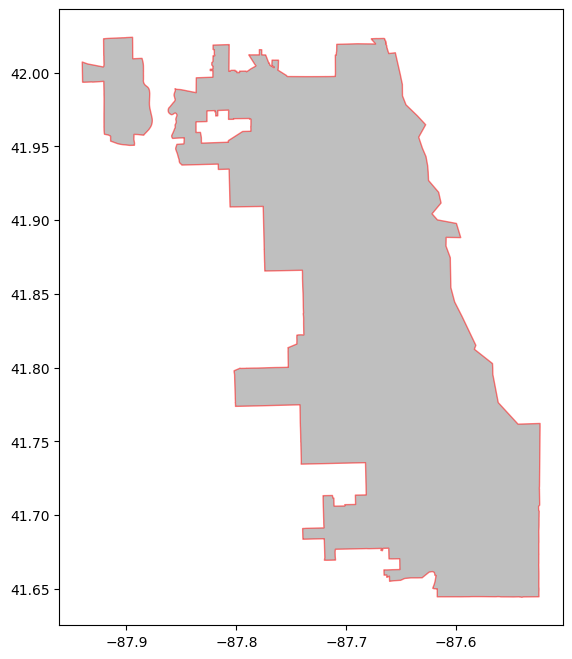

In [10]:
chicago_boundary = gpd.read_file("Chicago_Tracts_2010.zip")
multipolygon = chicago_boundary.dissolve(by=None)
fig, ax = plt.subplots(figsize=(8, 8))
multipolygon.plot(ax=ax, color='grey', edgecolor='red', alpha=0.5)

Text(0.5, 1.0, '(Test) Bird Migration Presence on 2025-07-15')

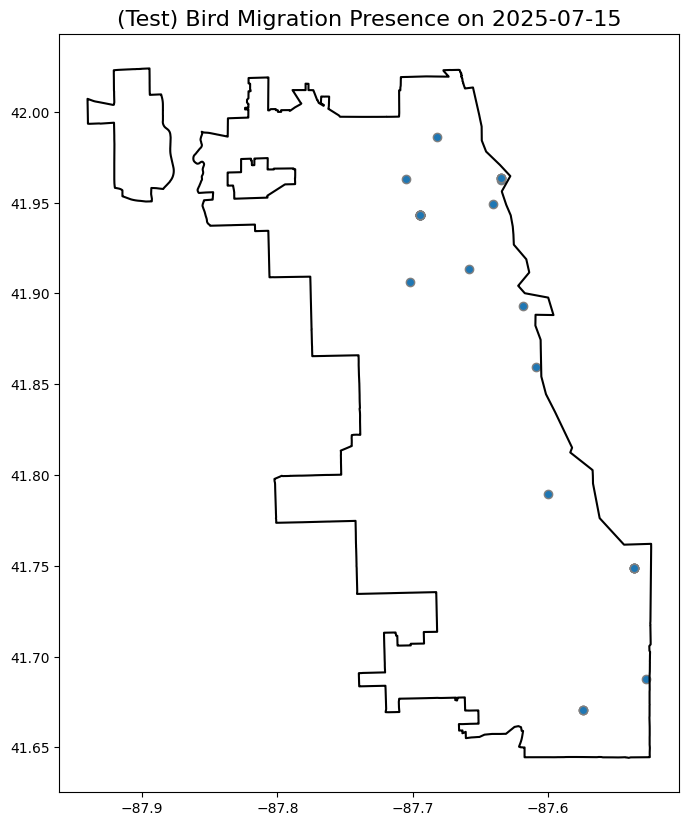

In [3]:
test = gpd.read_file("30d_bird_chicago/2025-07-15_bird_data.zip")
fig, ax = plt.subplots(figsize=(8, 10))

test.plot(ax=ax, edgecolor='grey', legend=True)

multipolygon.boundary.plot(ax=ax, color='black')

plt.title("(Test) Bird Migration Presence on 2025-07-15", fontsize=16)

In [4]:
## making the frames for the gif:
bird_presence_path = "./30d_bird_chicago"
frames_path = "bird_presence_frames"

os.makedirs(frames_path, exist_ok=True)

for daily_data in os.listdir(bird_presence_path):
    full_path = os.path.join(bird_presence_path, daily_data)

    gdf = gpd.read_file(full_path)

    fig, ax = plt.subplots(figsize=(8, 10))
    gdf.plot(ax=ax, color="red", edgecolor='grey', legend=True)
    multipolygon.boundary.plot(ax=ax, color='black')

    date = os.path.splitext(daily_data)[0][:10]
    plt.title(f"Migratory Birds Presence on {date}", fontsize=16)

    save_path = os.path.join(frames_path, f"bird_migration_presence_{date}.png")

    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

In [5]:
## creating the gif with the generated frames: 
gif_path = "bird_presence_animation.gif"

frames = [Image.open(os.path.join(frames_path, f)) for f in os.listdir(frames_path)]
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)

#### Bird Migration Hot Spot Density from June 15th to July 15th GIF

fix: keep legend normalized 

In [ ]:
## fix -> max not displaying/ being overwritten

gdf = gpd.read_file("./30d_bird_chicago/2025-06-18_bird_data.zip")

vmin = gdf["howMany"].min()
vmax = gdf["howMany"].max()

gdf
# max entries have double or more entries which overwrites the max val
# from locid keep the entries with max "howMany" value

gdf = gdf.loc[gdf.groupby('locId')['howMany'].idxmax()].reset_index(drop=True)
gdf

,speciesCod,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewe,locationPr,subId,exoticCate,geometry
0,rocpig,Rock Pigeon,Columba livia,L152691,"Lincoln Park, Chicago--North Pond",2025-06-18 17:27,16,41.928300,-87.637000,True,False,False,S251844102,N,POINT (-87.637 41.9283)
1,ribgul,Ring-billed Gull,Larus delawarensis,L152740,"Jackson Park, Chicago--Wooded Island/Bobolink ...",2025-06-18 18:10,5,41.785713,-87.582965,True,False,False,S251877246,None,POINT (-87.58296 41.78571)
2,banswa,Bank Swallow,Riparia riparia,L161180,"Montrose Point Bird Sanctuary, Lincoln Park, C...",2025-06-18 17:05,4,41.963383,-87.634420,True,False,False,S251933687,None,POINT (-87.63442 41.96338)
3,haiwoo,Hairy Woodpecker,Dryobates villosus,L164725,"Lincoln Park, Chicago--Jarvis Bird Sanctuary",2025-06-18 09:49,1,41.948994,-87.640700,True,False,False,S251726261,None,POINT (-87.6407 41.94899)
4,amecro,American Crow,Corvus brachyrhynchos,L20864270,Burnham Park--S Shore Drive near Burnham Playg...,2025-06-18 15:59,1,41.797066,-87.581530,True,False,True,S251878229,None,POINT (-87.58153 41.79707)
5,hoomer,Hooded Merganser,Lophodytes cucullatus,L298724,"Rosehill Cemetery, Chicago",2025-06-18 08:12,2,41.985983,-87.682003,True,False,False,S251697650,None,POINT (-87.682 41.98598)
6,comnig,Common Nighthawk,Chordeiles minor,L38527359,4724 Virginia,2025-06-18 21:49,1,41.966950,-87.699166,True,False,True,S251882640,None,POINT (-87.69917 41.96695)
7,coohaw,Cooper's Hawk,Astur cooperii,L4493848,5400 South Christiana,2025-06-18 18:38,1,41.795325,-87.707297,True,False,True,S252039203,None,POINT (-87.7073 41.79533)
8,bawwar,Black-and-white Warbler,Mniotilta varia,L950064,"Lincoln Park, Chicago--South Pond",2025-06-18 07:45,1,41.917352,-87.632961,True,True,False,S251691900,None,POINT (-87.63296 41.91735)


In [70]:
## making hotspot density maps for gif:
bird_presence_path = "./30d_bird_chicago"
hotspot_frames_path = "bird_hotspot_d_frames"

os.makedirs(hotspot_frames_path, exist_ok=True)

for daily_data in os.listdir(bird_presence_path):
    full_path = os.path.join(bird_presence_path, daily_data)

    gdf = gpd.read_file(full_path)
    gdf["howMany"] = gdf["howMany"].fillna(1)
    gdf = gdf.loc[gdf.groupby('locId')['howMany'].idxmax()].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(8, 10)) 

    vmin = gdf["howMany"].min()
    vmax = gdf["howMany"].max()
    
    gdf_plot = gdf.plot(
        column="howMany",
        ax=ax,
        cmap="coolwarm",
        legend=False
    )

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm._A = []

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.04,
        pad=0.02,
        aspect=20,
        shrink=0.4
    )
    cbar.set_label("Bird Abundance", fontsize=9)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_ticks([vmin, round((vmin + vmax) / 2), vmax])

    multipolygon.boundary.plot(ax=ax, color='black')

    date = os.path.splitext(daily_data)[0][:10]
    plt.title(f"Migratory Birds Presence on {date}", fontsize=16)

    save_path = os.path.join(hotspot_frames_path, f"bird_hotspot_density_{date}.png")

    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()

In [71]:
## creating the gif with the generated frames: 
gif_path = "bird_hotspot_d_animation.gif"

frames = [Image.open(os.path.join(hotspot_frames_path, f)) for f in os.listdir(hotspot_frames_path)]
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=900, loop=0)

#### SHAP Plot GIF

In [16]:
## creating the gif with the generated frames: 
shap_plot_frames = "shap_plots"
shap_gif_path = "shap_feature_importance.gif"

# re order the frames according to date first: 
# date_pattern = re.compile(r"(\d{2}_[A-Z]{3})")

# png_files = []
# for filename in os.listdir(shap_plot_frames):
#     if filename.endswith(".png"):
#         match = date_pattern.search(filename)
#         if match:
#             date_str = match.group(1)
#             try:
#                 date_obj = datetime.datetime.strptime(date_str, "%d_%b")
#                 png_files.append((filename, date_obj))
#             except ValueError:
#                 print(f"Skipping invalid date in: {filename}")

# png_files.sort(key=lambda x: x[1])

# for i, (filename, date_obj) in enumerate(png_files, start=1):
#     old_path = os.path.join(shap_plot_frames, filename)
#     new_filename = f"{i:03d}_{filename}"
#     new_path = os.path.join(shap_plot_frames, new_filename)
#     os.rename(old_path, new_path)
#     print(f"Renamed: {filename} --> {new_filename}")

In [17]:
frames = [Image.open(os.path.join(shap_plot_frames, f)) for f in os.listdir(shap_plot_frames)]
frames[0].save(shap_gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)

### Per-tract Bird Density plotting:

In [35]:
density = gpd.read_file("Chicago_CT_Point.csv")
density.columns

Index(['TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'Long', 'Lat',
       'GEOID_Matc', 'State', 'County', 'Community', 'Communit_1', '15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY'],
      dtype='object')

In [38]:
density["NAMELSAD10"].nunique()

798

using the chicago ct point csv:
- 798 unique tracts
- each tract has the avg daily density data for each of the 31 days
- I will plot -> 15_JUN data for each tract, as it should be different for all 798 tracts. 

In [8]:
target_vars = ['15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY']

In [39]:
len(target_vars)

31

In [6]:
gdf = gpd.read_file("Chicago_CT_Point.csv")

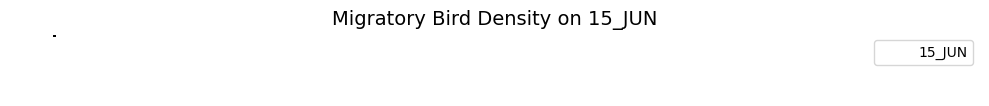

In [12]:
for target in target_vars[:1]: 

    fig, ax = plt.subplots(figsize=(10, 12)) 
    gdf[target] = pd.to_numeric(gdf[target])

    gdf.plot(
        column=target,
        ax=ax,
        cmap="Greys",
        legend=True,
        markersize=20,
        alpha=0.8
    )

    chicago_boundary.plot(ax=ax, edgecolor="black", color="white", alpha=0.5)

    ax.set_title(f"Migratory Bird Density on {target}", fontsize=14)
    ax.axis("off")
    plt.tight_layout()
    plt.show()


In [46]:
gdf.dtypes

TRACTCE10     object
GEOID10       object
NAME10        object
NAMELSAD10    object
Long          object
Lat           object
GEOID_Matc    object
State         object
County        object
Community     object
Communit_1    object
15_JUN        object
16_JUN        object
17_JUN        object
18_JUN        object
19_JUN        object
20_JUN        object
21_JUN        object
22_JUN        object
23_JUN        object
24_JUN        object
25_JUN        object
26_JUN        object
27_JUN        object
28_JUN        object
29_JUN        object
30_JUN        object
01_JLY        object
02_JLY        object
03_JLY        object
04_JLY        object
05_JLY        object
06_JLY        object
07_JLY        object
08_JLY        object
09_JLY        object
10_JLY        object
11_JLY        object
12_JLY        object
13_JLY        object
14_JLY        object
15_JLY        object
dtype: object

TypeError: no numeric data to plot

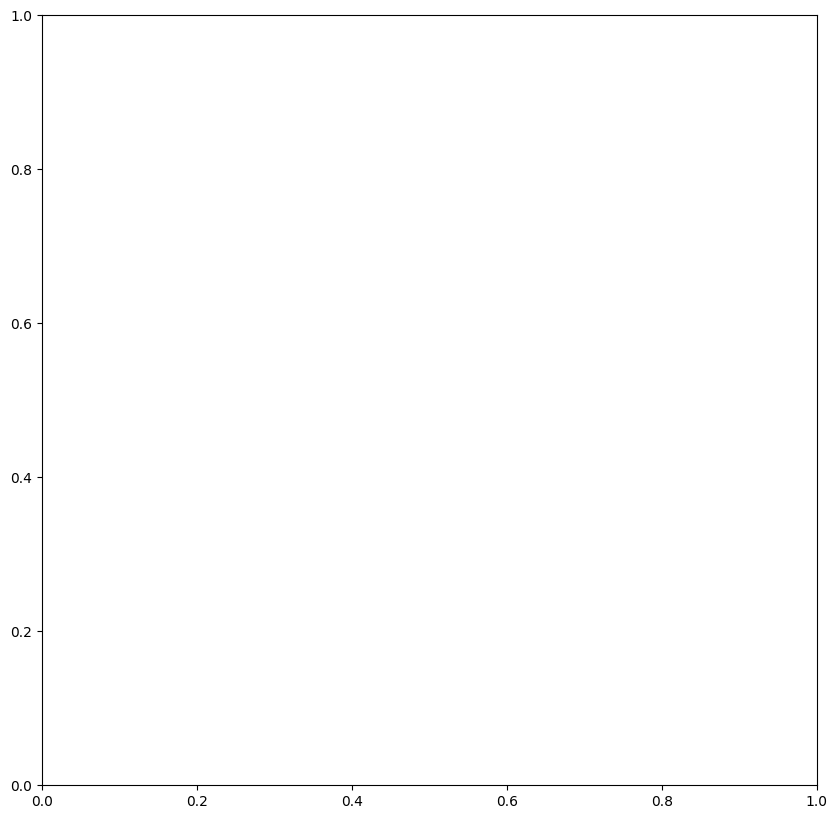

In [44]:
# Merge on tract ID
merged = gdf.merge(gdf[['NAMELSAD10', '15_JUN']], on='NAMELSAD10', how='left')

fig, ax = plt.subplots(figsize=(10, 10))

merged.plot(column="15_JUN",
            cmap="Greys",
            legend=True,
            linewidth=0.2,
            edgecolor='black',
            ax=ax)

ax.set_title("Hotspot Density by Tract - 15 June", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
## making hotspot density maps for gif:
bird_presence_path = "./30d_bird_chicago"
density_frames = "bird_density_frames"

os.makedirs(hotspot_frames_path, exist_ok=True)

for daily_data in os.listdir(bird_presence_path):
    full_path = os.path.join(bird_presence_path, daily_data)

    gdf = gpd.read_file(full_path)
    gdf["howMany"] = gdf["howMany"].fillna(1)
    gdf = gdf.loc[gdf.groupby('locId')['howMany'].idxmax()].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(8, 10)) 

    vmin = gdf["howMany"].min()
    vmax = gdf["howMany"].max()
    
    gdf_plot = gdf.plot(
        column="howMany",
        ax=ax,
        cmap="coolwarm",
        legend=False
    )

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm._A = []

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.04,
        pad=0.02,
        aspect=20,
        shrink=0.4
    )
    cbar.set_label("Bird Abundance", fontsize=9)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_ticks([vmin, round((vmin + vmax) / 2), vmax])

    multipolygon.plot(ax=ax, color='black')

    date = os.path.splitext(daily_data)[0][:10]
    plt.title(f"Migratory Birds Presence on {date}", fontsize=16)

    save_path = os.path.join(hotspot_frames_path, f"bird_hotspot_density_{date}.png")

    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()